In [4]:
%matplotlib inline
import os
import sys
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import cmath

from datetime import datetime, date

from sktensor import dtensor, cp_als
# matplotlib.style.use('ggplot')


from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import precision_recall_curve, average_precision_score
from sktensor import dtensor, cp_als

matplotlib.style.use('ggplot')

In [5]:
# Downloading and preprocessing the dataset
# The variable "tab" has integers datetime
execfile('Library/Initialization_rado_month.py')
T.shape

82927 mails exchanged between 167 employees from 2010-01-02 17:40:10 to 2010-09-30 22:08:12
6.20716691017


(167, 167, 9)

### Dataset Temporal Split
We use (sender,receiver)_t matrix for t between t_0 and t_1. This temporal window shifts as t_0 incresases.  
t_0 is s.t. t_0+t_1 <= T.shape[2] = 9  
  
Since we would like to move this window around 3 weeks, we choose t_0 <= 21 and a constant window size of length 238-21=217

In [10]:
t_0 = 0
t_1 = t_0 + 5

if t_1 <= T.shape[2]:
    T_train = T[:, :, t_0:t_1]
    T_test = T[:, :, t_1:]
    print('Initial time: t_0 = %d [%s]\nFinal time:   t_1 = %d [%s]') %(t_0,
                                                                                  k_list[t_0],
                                                                                  t_1,
                                                                                  k_list[t_1])
else:
    print('t_0=%d is superior to the maximal value 21!') %(t_0)

Initial time: t_0 = 0 [1]
Final time:   t_1 = 5 [6]


In [11]:
#Proportion of non-zero entries of the tensor
mail_rate = np.count_nonzero(T) / float(T.shape[0] * T.shape[1] * T.shape[2])

In [12]:
# Collapsed weighted tensor
CT = np.zeros((T[:,:,0].shape[0], T[:,:,0].shape[1]))
theta = 0.2
K = len(k_list)

for k in range(K):
    CT = CT + (1-theta)**(K - k)*T[:,:,k]

In [13]:
CT

dtensor([[  0.        ,  10.77385632,  10.87082853, ...,   0.        ,
          0.        ,   0.        ],
       [  6.48481475,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  6.25471986,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

### TSVD

In [14]:
U, Sigma, Vt = randomized_svd(CT, n_components=15, n_iter=5, random_state=None)

In [15]:
U.shape

(167, 15)

In [16]:
Vt.shape

(15, 167)

In [17]:
len(Sigma)

15

In [18]:
TSVDScore = np.dot(np.dot(U,np.diag(Sigma)),Vt)

In [19]:
TSVDScore

array([[  8.66680663e-03,   9.90323324e+00,   1.11704930e+01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.15195536e+00,   4.42569802e+00,  -8.29529182e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  8.11221108e+00,  -6.86893371e-02,  -6.70470234e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [20]:
S = TSVDScore

In [22]:
#Converting S into S_pred, a binary matrix
thres = 1  # If the score above thres, we predict an email

S_pred = (1*(S >= thres))
S_test = (1*np.array(T_test[:, :, 0] >= 1))

### Precision-Recall for several values of K

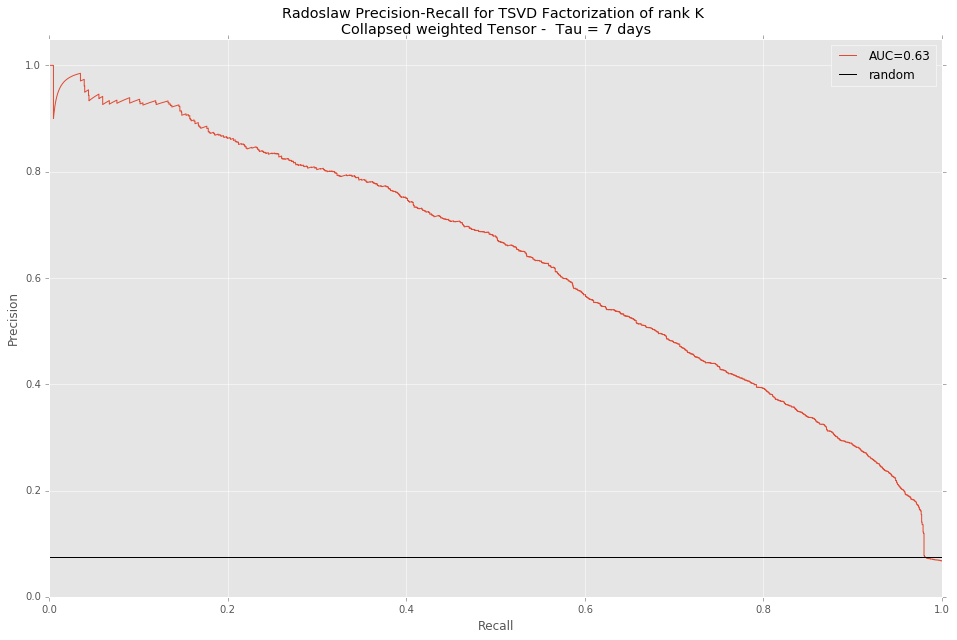

In [66]:
tau = 7
theta = 0.2

# TSVD Decomposition
U, Sigma, Vt = randomized_svd(CT, n_components=K, n_iter=5, random_state=None)
# TSVD Scoring
S = np.dot(np.dot(U,np.diag(Sigma)),Vt)

y_score = S.flatten()
y_test = S_test.flatten()
    
# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)    

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

plt.plot(recall, precision, label='AUC={0:0.2f}' .format(average_precision))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw Precision-Recall for TSVD Factorization of rank K \nCollapsed weighted Tensor -  Tau = %d days' %(tau))
plt.savefig('Radoslaw TSVD_roc_cut_%d.png' %(tau))    

### Katz score

In [37]:
#Converting S into S_pred, a binary matrix
#thres = 1  # If the score above thres, we predict an email

#S_pred = (1*(S >= thres))
S_test = (1*np.array(T_test[:, :, 0] >= 1))

### Precision-Recall for several values of K

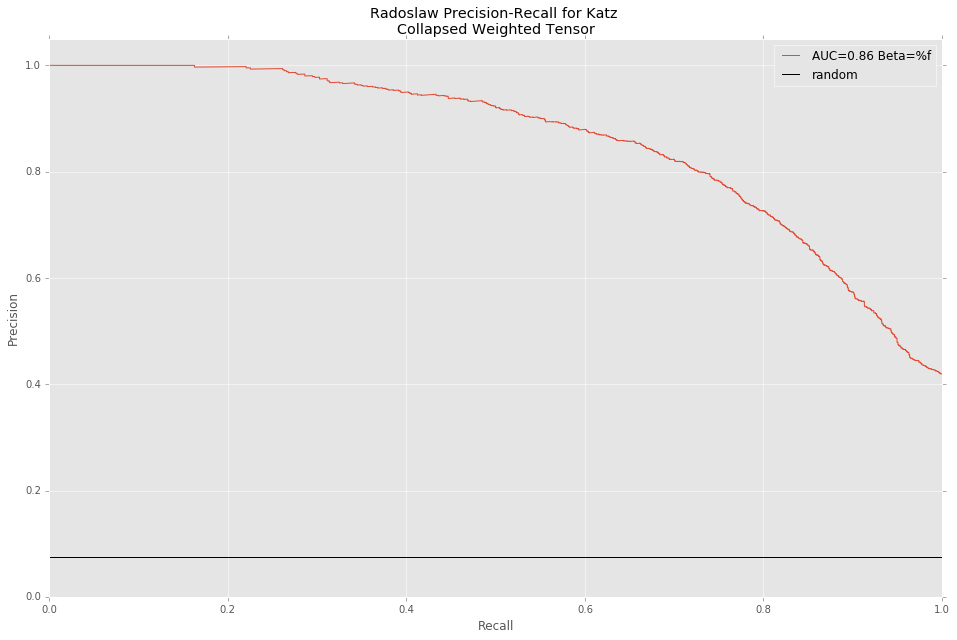

In [65]:
beta = 0.001
k_ = len(k_list)

# Katz Scoring
S = np.linalg.inv((np.eye(CT.shape[0]) - beta*CT)) - np.eye(CT.shape[0])

y_score = S.flatten()
y_test = S_test.flatten()  

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)    

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

plt.plot(recall, precision, label='AUC={0:0.2f} Beta=%f' .format(average_precision))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw Precision-Recall for Katz \nCollapsed Weighted Tensor')
plt.savefig('Radoslaw Katz_roc_cut_%d.png' %(beta))     

### TKatz

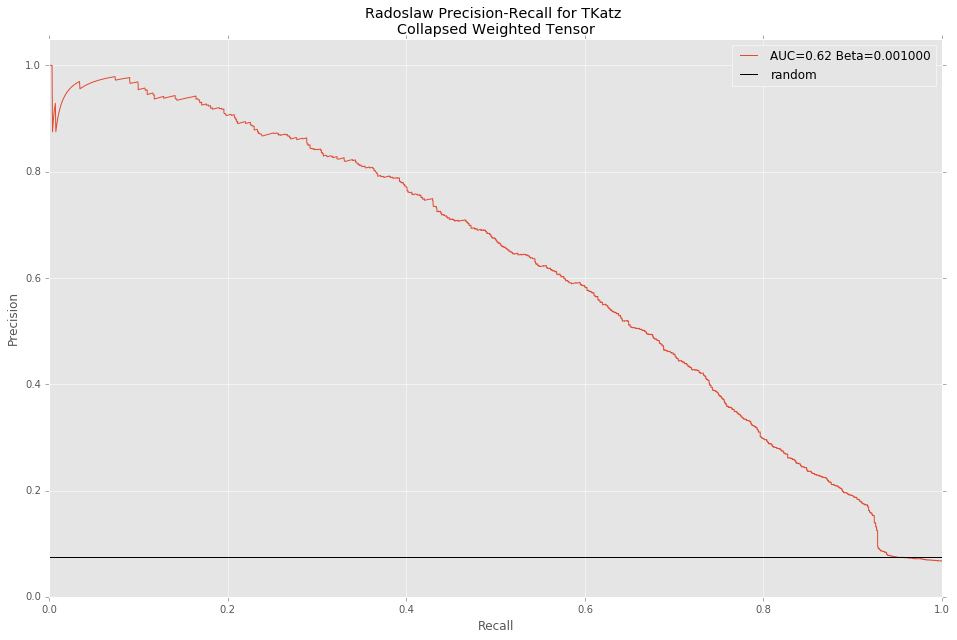

In [64]:
beta_list = 0.001

D, W = np.linalg.eig((CT))

alpha = []
for i in D :
    alpha += [1./(1-beta*i) - 1] 
    
# TKatz Scoring
S = np.dot(W,np.dot(np.diag(alpha),W.transpose()))

y_score = S.flatten()
y_test = S_test.flatten() 

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)    

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

plt.plot(recall, precision, label='AUC={0:0.2f} Beta=%f' .format(average_precision) %(beta))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw Precision-Recall for TKatz \nCollapsed Weighted Tensor')
plt.savefig('Radoslaw Tkatz_roc_cut_%d.png' %(beta))     